In [ ]:
!pip install transformers torch quantstats pyfolio yfinance stable_baselines3 streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import streamlit as st
import quantstats as qs

In [ ]:
def fetch_data(tickers, start="2015-01-01", end="2024-01-01"):
    df = yf.download(tickers, start=start, end=end, group_by="ticker", auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex):
        df = df[tickers[0]].copy()
    df = df.reset_index()

    # Technical indicators
    df['SMA'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = df['Close'].rolling(window=14).apply(
        lambda x: 100 - (100 / (1 + (x.diff().clip(lower=0).sum() / -x.diff().clip(upper=0).sum())))
    )
    df['Price_Change'] = df['Close'].pct_change()

    # 🎯 Add FinBERT sentiment
    tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')
    model = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
    headlines = ["Stocks rise as investors gain confidence"] * len(df)  # 🔥 Dummy headlines (replace with real)
    sentiment_scores = []
    for text in headlines:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        outputs = model(**inputs)
        probs = F.softmax(outputs.logits, dim=1)
        sentiment_scores.append((probs[:, 2] - probs[:, 0]).item())  # Positive - Negative
    df['Sentiment_Score'] = sentiment_scores

    df.dropna(inplace=True)
    return df

# 📊 Preprocess data
def preprocess_data(df):
    df = df.copy()
    df = df.dropna()
    return df

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F

class TradingEnvironment(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, data, initial_balance=10000):
        super(TradingEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance

        # Action space: 0 = hold, 1 = buy, 2 = sell
        self.action_space = spaces.Discrete(3)

        # Observation space: [Close, SMA, RSI, Balance, Holdings, Sentiment]
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32
        )

        # FinBERT for sentiment analysis
        self.tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
        self.model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def _get_sentiment_score(self, text=None):
        return 0.0  # No sentiment data available

        # Tokenize and predict
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = self.model(**inputs)
            probs = F.softmax(outputs.logits, dim=-1)
            sentiment_score = probs[0][2].item() - probs[0][0].item()  # positive - negative
        return sentiment_score

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.holdings = 0
        self.total_shares_sold = 0
        self.total_sales_value = 0

        # Get sentiment for current step
        sentiment = self._get_sentiment_score()


        # Observation vector
        obs = np.array([
            self.data.loc[self.current_step, "Close"],
            self.data.loc[self.current_step, "SMA"],
            self.data.loc[self.current_step, "RSI"],
            self.balance,
            self.holdings,
            sentiment
        ], dtype=np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        # Terminate episode if end of data
        terminated = self.current_step >= len(self.data) - 1
        truncated = False

        # Get sentiment for current step
        sentiment = self._get_sentiment_score(self.data.loc[self.current_step, "Headline"])

        # Observation vector
        obs = np.array([
            self.data.loc[self.current_step, "Close"],
            self.data.loc[self.current_step, "SMA"],
            self.data.loc[self.current_step, "RSI"],
            self.balance,
            self.holdings,
            sentiment
        ], dtype=np.float32)

        # Reward is change in net worth
        reward = self.net_worth - self.initial_balance

        info = {
            "net_worth": self.net_worth,
            "balance": self.balance,
            "holdings": self.holdings
        }

        return obs, reward, terminated, truncated, info

    def _take_action(self, action):
        current_price = self.data.loc[self.current_step, "Close"]
        if action == 1:  # buy
            if self.balance > current_price:
                self.holdings += 1
                self.balance -= current_price
        elif action == 2:  # sell
            if self.holdings > 0:
                self.holdings -= 1
                self.balance += current_price
                self.total_shares_sold += 1
                self.total_sales_value += current_price

        self.net_worth = self.balance + self.holdings * current_price

    def render(self, mode="human"):
        print(f"Step: {self.current_step}")
        print(f"Balance: {self.balance:.2f}")
        print(f"Holdings: {self.holdings}")
        print(f"Net Worth: {self.net_worth:.2f}")

    def close(self):
        pass


In [ ]:
tickers = ["AAPL"]
data = fetch_data(tickers)
data = preprocess_data(data)

# 🔥 Add dummy headlines for FinBERT (to avoid KeyError)
data["Headline"] = "The stock market is stable."  # Dummy sentiment headline

# Set up environment and train model
env = DummyVecEnv([lambda: TradingEnvironment(data)])
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
# Record Net_Worth after training
net_worths = []
env_instance = TradingEnvironment(data)
obs, _ = env_instance.reset()
done = False

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env_instance.step(action)
    net_worths.append(info['net_worth'])
    done = terminated or truncated

# Add Net_Worth column to data
data["Net_Worth"] = pd.Series(net_worths)

model.save("ppo_trading_agent")


[*********************100%***********************]  1 of 1 completed
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1016 |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 726          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 7.807501e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -1.36e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.83e+08     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000158    |
|    value_loss           | 4.17e+08     |
------------------------------------------

[Performance Metrics]



                           Strategy
-------------------------  ----------
Start Period               2015-02-02
End Period                 2023-12-29
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          634.32%
CAGR﹪                     16.71%

Sharpe                     0.92
Prob. Sharpe Ratio         99.69%
Smart Sharpe               0.85
Sortino                    1.34
Smart Sortino              1.24
Sortino/√2                 0.95
Smart Sortino/√2           0.88
Omega                      1.18

Max Drawdown               -38.52%
Max DD Date                2019-01-03
Max DD Period Start        2018-10-04
Max DD Period End          2019-10-09
Longest DD Days            617
Volatility (ann.)          28.95%
Calmar                     0.43
Skew                       -0.03
Kurtosis                   5.36

Expected Daily %           0.09%
Expected Monthly %         1.88%
Expected Yearly %          24.8%
Kelly Criterion            8.1%
Risk of Ruin

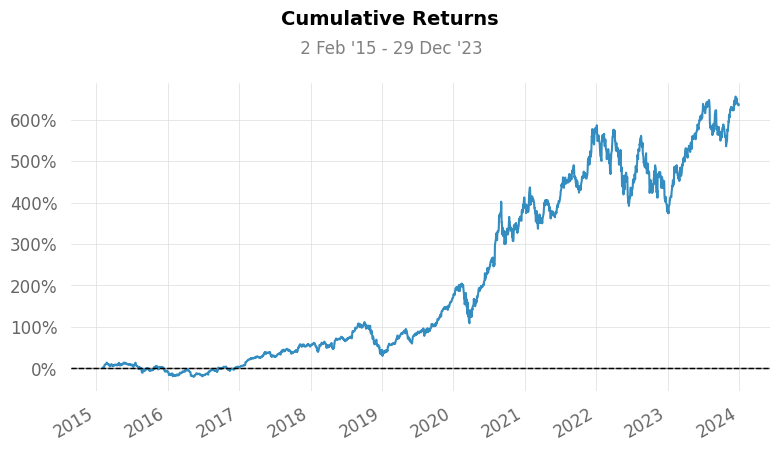

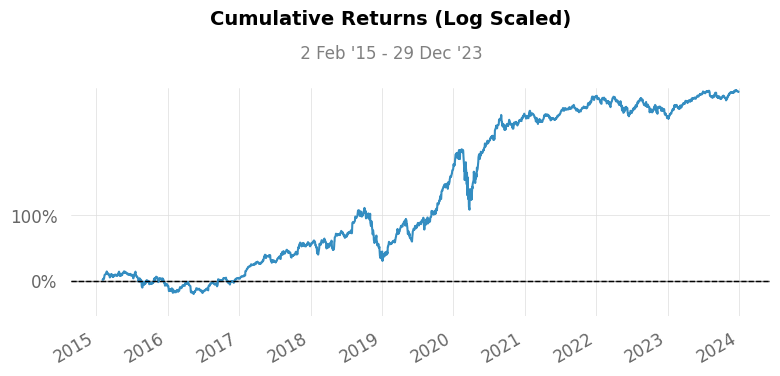

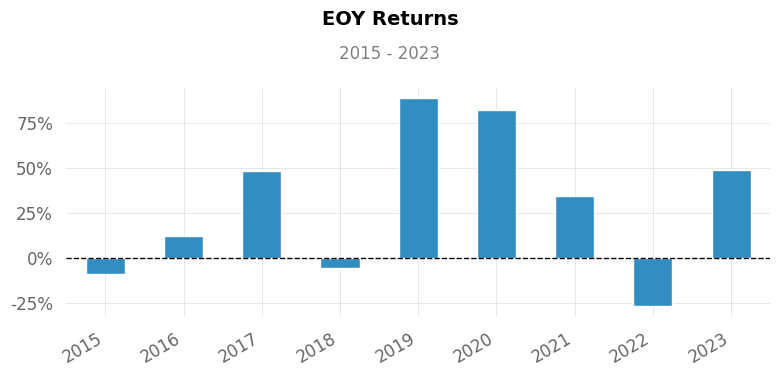

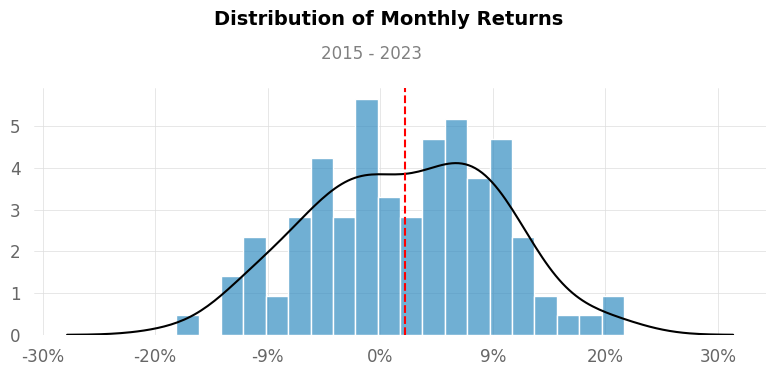

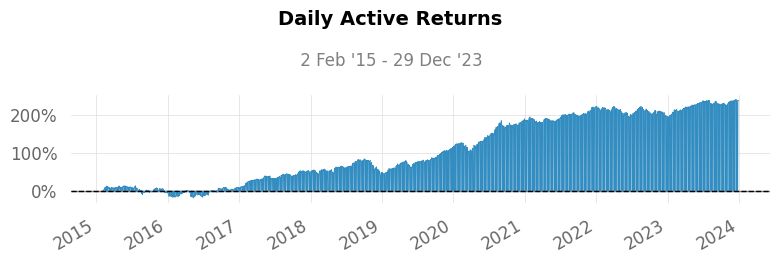

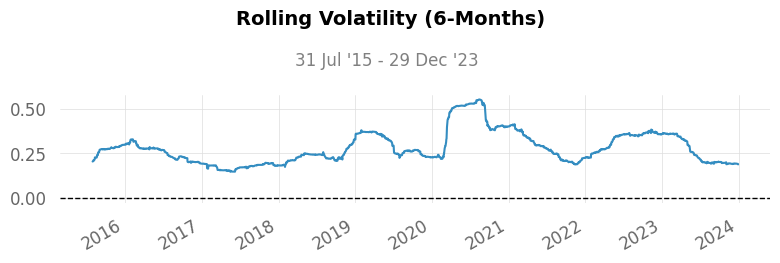

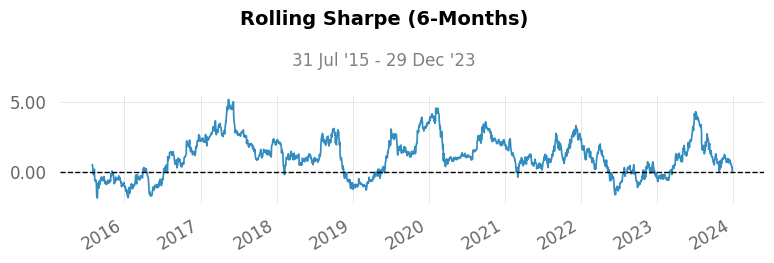

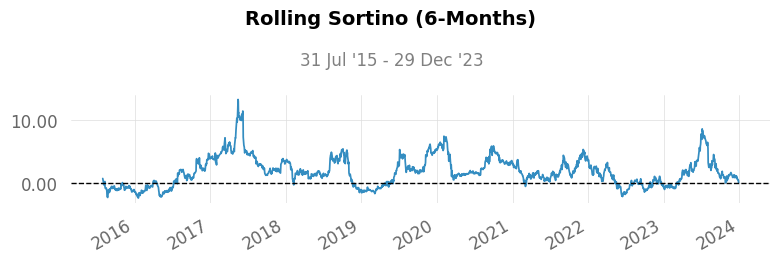

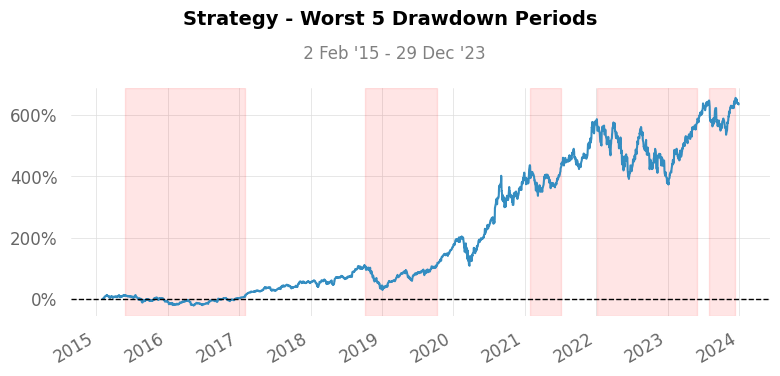

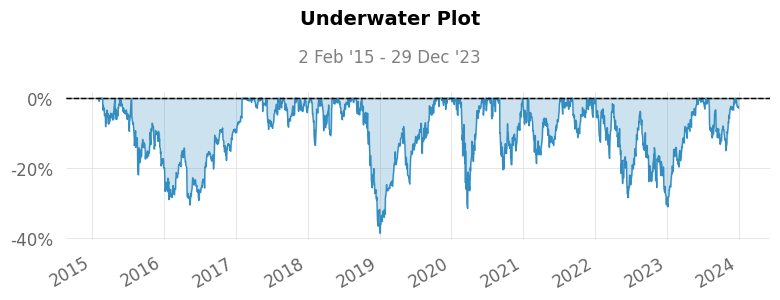

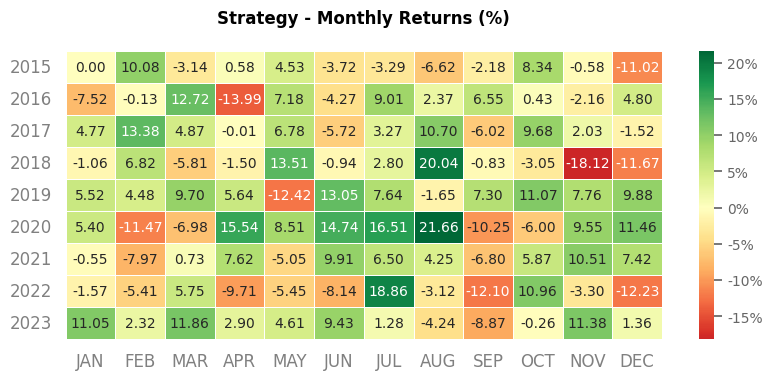

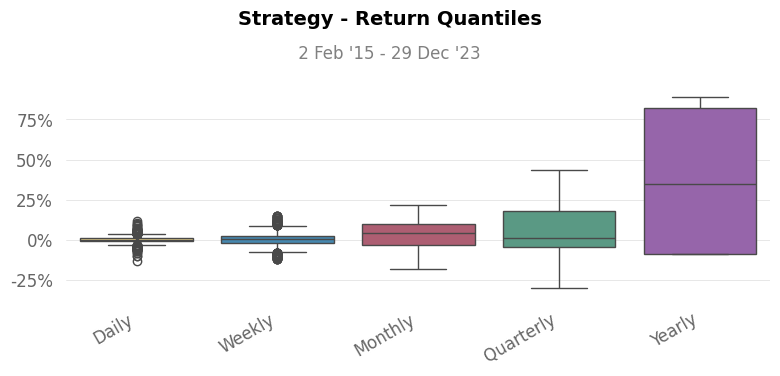

In [ ]:
returns = data.set_index("Date")['Price_Change'].iloc[1:]
qs.reports.full(returns, title="DRL Agent Backtest Report")

In [ ]:
st.title("📈 Trading Environment Dashboard")
st.line_chart(data.set_index('Date')['Close'])
st.line_chart(data.set_index('Date')['Sentiment_Score'])
st.line_chart(data.set_index('Date')['Net_Worth'])

2025-07-14 15:42:08.126 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.128 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.129 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.198 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.199 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.267 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-14 15:42:08.272 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [ ]:
!pip install pyngrok

In [80]:
%%writefile app.py
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import random
from transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import streamlit as st

# 🚀 Fetch & preprocess data
def fetch_data(tickers, start="2015-01-01", end="2024-01-01"):
    df = yf.download(tickers, start=start, end=end, group_by="ticker", auto_adjust=True)
    if isinstance(df.columns, pd.MultiIndex):
        df = df[tickers[0]].copy()
    df.reset_index(inplace=True)
    df['SMA'] = df['Close'].rolling(window=20).mean()
    df['RSI'] = df['Close'].rolling(window=14).apply(
        lambda x: 100 - (100 / (1 + (x.diff().clip(lower=0).sum() / -x.diff().clip(upper=0).sum())))
    )
    df['Price_Change'] = df['Close'].pct_change()
    df['Headline'] = ["Market steady"] * len(df)  # Dummy headline
    df.dropna(inplace=True)
    return df

# 🌟 Trading Environment
class TradingEnvironment(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(TradingEnvironment, self).__init__()
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        self.reset()

    def reset(self, *, seed=None, options=None):
        self.current_step = 0
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.holdings = 0
        return self._next_observation(), {}

    def _next_observation(self):
        row = self.data.iloc[self.current_step]
        return np.array([
            row['Close'],
            row['SMA'],
            row['RSI'],
            self.balance,
            self.holdings,
            random.uniform(-1, 1)  # Dummy sentiment score
        ], dtype=np.float32)

    def step(self, action):
        current_price = self.data.loc[self.current_step, "Close"]
        if action == 1 and self.balance >= current_price:
            self.holdings += 1
            self.balance -= current_price
        elif action == 2 and self.holdings > 0:
            self.holdings -= 1
            self.balance += current_price

        self.current_step += 1
        self.net_worth = self.balance + self.holdings * current_price

        terminated = self.current_step >= len(self.data) - 1
        reward = self.net_worth - self.initial_balance
        info = {"net_worth": self.net_worth}
        return self._next_observation(), reward, terminated, False, info


# 🔥 Run agent

def run_agent(model, data):
    # Wrap the TradingEnvironment in DummyVecEnv
    env = DummyVecEnv([lambda: TradingEnvironment(data)])

    # Reset environment and get initial observation
    obs = env.reset()  # Only returns obs, no info

    net_worths = []
    for step in range(len(data) - 1):
        action, _states = model.predict(obs, deterministic=True)
        obs, rewards, dones, infos = env.step(action)  # returns 4 items
        net_worths.append(infos[0]['net_worth'])  # infos is a list of dicts

        if dones[0]:  # Check first env done flag
            break

    result_df = pd.DataFrame({
        "Date": data["Date"].iloc[:len(net_worths)],
        "Net_Worth": net_worths
    })
    return result_df

# 📊 Streamlit UI
st.title("📈 DRL Trading Agent Dashboard")
ticker_input = st.text_input("Enter Stock Ticker:", "AAPL")
start_date = st.date_input("Start Date", pd.to_datetime("2015-01-01"))
end_date = st.date_input("End Date", pd.to_datetime("2024-01-01"))

if st.button("Run Agent"):
    st.write("Fetching data...")
    data = fetch_data([ticker_input], start=start_date, end=end_date)

    st.write("Loading model...")
    model = PPO.load("ppo_trading_agent.zip")

    st.write("Simulating agent...")
    result_df = run_agent(model, data)

    st.line_chart(result_df.set_index("Date")["Net_Worth"])
    st.success("✅ Simulation Complete!")


Overwriting app.py


In [81]:
# Set up ngrok
from pyngrok import ngrok
!pkill -f ngrok

# 🔑 Set your ngrok authtoken (replace with your token)
ngrok.set_auth_token("2zsAmTCbkComj4hYKqaQaDg1oT5_kdaKDAmA9Tx62uE1a6KS")

# Start Streamlit
!streamlit run app.py &>/dev/null &

# Expose Streamlit app via ngrok
public_url = ngrok.connect(8501)
print(f"🚀 Your Streamlit app is live here: {public_url}")



🚀 Your Streamlit app is live here: NgrokTunnel: "https://ee8d681164bf.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
%%writefile app.py